In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import scipy.stats as st

In [2]:

# Estimate secretion rate
fn_exometabolites = "../../data/e_coli/ecoli_exometabolites.csv"
fn_exometabolites_std = "../../data/e_coli/ecoli_exometabolites_std.csv"
exometabolites_folder = "../../data/e_coli/"
organism = "ecoli"

exometabolites_folder = Path(exometabolites_folder)
fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [3]:
df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
df_OD = pd.read_csv(fn_OD, index_col=0)

In [4]:
def get_leakage(data_folder, organism, time):
    exometabolites_folder = Path(data_folder)
    
    # Filenames
    fn_exometabolites = exometabolites_folder / "{0}_exometabolites.csv".format(organism)
    fn_exometabolites_std = exometabolites_folder / "{0}_exometabolites_std.csv".format(organism)
    fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)
    
    # Read files as dataframes
    df_exometabolites = pd.read_csv(fn_exometabolites, index_col=0)
    df_exometabolites_std = pd.read_csv(fn_exometabolites_std, index_col=0)
    df_OD = pd.read_csv(fn_OD, index_col=0)
    
    met_abbreviations = [x.replace(" MS", "") for x in df_exometabolites.columns]
    leakage_list = []
    leakage_uncertainty_list = []
    for met_abbrv in met_abbreviations:
        leakage, std = estimate_leakage_rate_for_met(time, met_abbrv, df_OD, df_exometabolites, df_exometabolites_std)
        leakage_list.append(leakage)
        leakage_uncertainty_list.append(std)
    #print(leakage_list)
    leakage_df = pd.DataFrame({"Metabolite": met_abbreviations, "Leakage (uM/h/OD)":leakage_list,"Leakage std": leakage_uncertainty_list})#, columns = ["Time", , "Leakage std"])
    return leakage_df
    
    

def estimate_leakage_rate_for_met(time, met_abbrv, df_OD, df_exometabolites, df_exometabolites_std):
    """
    Estimate leakage by dividing the change in concentration of two timepoints by the OD of the mean.
    Time = 6 or 7 seems to be mid-exponential phase
    """
    OD_mean = df_OD.loc[time, "OD mean"]
    OD_std = df_OD.loc[time, "OD std"]
    
    # met_conc
    met_conc_1 = df_exometabolites.loc[time-1, met_abbrv]
    met_conc_2 = df_exometabolites.loc[time+1, met_abbrv]
    met_conc_1_std = df_exometabolites_std.loc[time-1, met_abbrv]
    met_conc_2_std = df_exometabolites_std.loc[time+1, met_abbrv]
    
    # leakage rate
    delta_time = 2 # Divide by delta time = 2 hours
    leakage_per_h = (met_conc_2 - met_conc_1) / delta_time 
    leakage_rate_per_h_per_OD = leakage_per_h / OD_mean
    
    if leakage_per_h != 0:
        # Error propagation
        # Assume no covariance; https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae
        leakage_per_h_std = np.sqrt(met_conc_1_std**2 + met_conc_2_std**2)/delta_time
        #print(leakage_per_h_std, leakage_per_h, OD_std, OD_mean)
        rel_leakage_std = np.sqrt((leakage_per_h_std/leakage_per_h)**2+(OD_std/OD_mean)**2)
        leakage_std = rel_leakage_std*leakage_rate_per_h_per_OD
    else:
        leakage_std = 0
    return leakage_rate_per_h_per_OD, leakage_std
    
    
    #
    

In [5]:
leakage_df = get_leakage(exometabolites_folder, "ecoli", time = 7)
leakage_df.set_index("Metabolite", inplace=True)

In [15]:
leakage_df

,Leakage (uM/h/OD),Leakage std
Metabolite,,
G6P,0.440616,0.015430
F6P,0.718007,0.033832
FBP,0.359004,0.014058
DHAP,0.627496,0.065091
GA3P,0.186804,0.014218
23PG,0.254953,0.023705
PEP,0.069823,0.006347
R5P,0.092261,0.004086
RU5P+X5P,0.041445,0.003663


In [7]:
# Cost of synthesis

In [8]:
fn_cost = exometabolites_folder / "cost_of_aa_biosynthesis.csv"
df_cost = pd.read_csv(fn_cost, index_col=0, skiprows=3, header = [0,1])

In [16]:
leakage = []
total_cost_glucose = []
aa_list = []
leakage_error = []

for aa, row in df_cost.iterrows():
    try:
        leak = leakage_df.loc[aa.upper(), "Leakage (uM/h/OD)"]
    except KeyError:
        continue
    else:
        if leak > 0 and (leak > leakage_df.loc[aa.upper(), "Leakage std"]):
            # I dicard those metabolites where 0 is included in mean+- 1 std -> Doesn't work well when log-transformed errorbar plot
            leakage.append(leak)
            leakage_error.append(leakage_df.loc[aa.upper(), "Leakage std"])
            total_cost_glucose.append(row["Glucose"]["Total, ~P"])
            aa_list.append(aa)
leakage = np.array(leakage)
leakage_error = np.array(leakage_error)

# Plot

[('Ala', 0.17936263340222536, -1.5625406787182077, 0.3109946215705941), ('Asp', 0.020252274777468493, -1.6106502541339016, 0.021243082985248574), ('Phe', 0.08696694131946892, -2.3687206527020948, 0.10885668575919594), ('His', 0.27577058507204644, -1.7038698310970861, 0.9468995962176765), ('Leu', 0.012520164408077461, -1.5480084724779442, 0.012891846659217387), ('Met', 0.044165688503070566, -2.309283464850227, 0.04917093953472307), ('Pro', 0.09301648268054796, -2.159801784778168, 0.11852609842920891), ('Arg', 0.15339881699734814, -0.9537473047312771, 0.23930279602018667), ('Thr', 0.1328841101078133, -1.3002874001876923, 0.1924318490902459), ('Val', 0.037636536884150695, -1.5670883064689285, 0.04121032656883483), ('Trp', 0.12911735322627793, -2.805503340878156, 0.1845710767640556), ('Tyr', 0.1811832500672863, -2.9727151360519977, 0.3166742919924972)]


<ErrorbarContainer object of 3 artists>

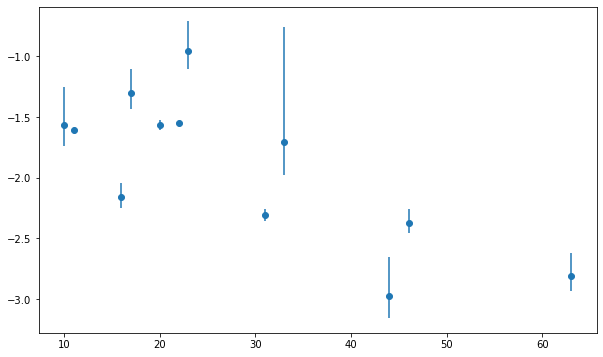

In [17]:
fig, ax = plt.subplots(1, figsize = (10,6))
label_fontsize = 16
log10_leakage = np.log10(leakage)
error_min = log10_leakage - np.log10(leakage-leakage_error)
error_max = np.log10(leakage+leakage_error)-log10_leakage

print([(aa, x,y,z) for aa,x,y,z in zip(aa_list, error_max, log10_leakage, error_min)])
#ax.plot(log10_leakage, total_cost_glucose)
ax.errorbar(y = log10_leakage, x = total_cost_glucose, yerr = [error_max, error_min], fmt='o')
#ax.set_xlabel(r"log$_{10}$(leakage rate [μM/h/OD])", fontdict={"size": label_fontsize})
#ax.set_ylabel("Cost of biosynthesis [~P]", fontdict={"size": label_fontsize})
#for i, aa in enumerate(aa_list):
#    ax.annotate(aa, (log10_leakage[i]+0.02, total_cost_glucose[i]), size = 12)

In [132]:
error_min

NameError: name 'error_min' is not defined

In [12]:
error_max

array([0.17936263, 0.02025227, 0.08696694, 0.40253091, 0.27577059,
       0.01252016, 0.04416569, 0.09301648, 0.15339882, 0.13288411,
       0.03763654, 0.12911735, 0.18118325])

In [90]:
st.pearsonr(np.log(leakage), total_cost_glucose)

(-0.7083211449667639, 0.0067345393436468075)

In [71]:
df_cost

Unnamed: 1_level_0       Unnamed: 2_level_0 Glucose                \
Amino acid   One-lettersymbol    Precursor metabolites      ~P   H Total, ~P   
Ala                         A                      pyr       0   5      10.0   
Cys                         C                      3pg       7   8      23.0   
Asp                         D                      oaa       1   5      11.0   
Glu                         E                      αkg       1   5      11.0   
Phe                         F              2 pep, eryP      10  18      46.0   
Gly                         G                      3pg       2   4      10.0   
His                         H                     penP      15   9      33.0   
Ile                         I                 pyr, oaa       3  13      29.0   
Lys                         K                 oaa, pyr       3  12      27.0   
Leu                         L             2 pyr, acCoA       0  11      22.0   
Met                         M           oaa, Cys, -pyr       9  11      31.0   
Asn                         N                      oaa       3   5      13.0   
Pro                         P                      αkg       2   7      16.0   
Gln                         Q                      αkg       2   5      12.0   
Arg                         R                      αkg       9   7      23.0   
Ser                         S                      3pg       2   4      10.0   
Thr                         T                      oaa       3   7      17.0   
Val                         V                    2 pyr       0  10      20.0   
Trp                         W  2 pep, eryP, PRPP, -pyr      19  22      63.0   
Tyr                         Y              eryP, 2 pep      10  17      44.0   

           Acetate               Malate                    Mean  
Amino acid      ~P   H Total, ~P     ~P   H Total, ~P Total, ~P  
Ala              2   6      14.0      1   5      11.0     11.67  
Cys              8   9      26.0      7   9      25.0     24.67  
Asp              2   6      14.0      1   6      13.0     12.67  
Glu              5   8      21.0      2   6      14.0     15.33  
Phe             18  20      58.0     12  20      52.0     52.00  
Gly              3   5      13.0      2   5      12.0     11.67  
His             27   9      45.0     19   9      37.0     38.33  
Ile              6  15      36.0      4  14      32.0     32.33  
Lys              6  14      34.0      4  13      30.0     30.33  
Leu              5  15      35.0      3  11      25.0     27.33  
Met             11  13      37.0      9  13      35.0     34.33  
Asn              4   6      16.0      3   6      15.0     14.67  
Pro              6  10      26.0      3   8      19.0     20.33  
Gln              6   8      22.0      3   6      15.0     16.33  
Arg             13  10      33.0     10   8      26.0     27.33  
Ser              3   5      13.0      2   5      12.0     11.67  
Thr              4   8      20.0      3   8      19.0     18.67  
Val              4  12      28.0      2  10      22.0     23.33  
Trp             39  24      87.0     25  24      73.0     74.33  
Tyr             18  19      56.0     12  19      50.0     50.00

In [70]:
for aa, row in df_cost.iterrows()

SyntaxError: invalid syntax (1235550426.py, line 1)

In [19]:
df_exometabolites

,G6P,F6P,FBP,DHAP,GA3P,23PG,PEP,R5P,RU5P+X5P,E4P,...,LEU,TRP,HIS,ARG,PYR,ORO,FUM,URA,AKG,ACT
Time,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.101467,0.446667,0.000000,0.190667,0.024512,0.054400,0.000000,0.003685,0.000000,0.000000,...,0.041667,0.031867,4.690000,0.138467,0.00,8.00,13.50,88.50,0.0,444.00
2,0.277733,0.782667,0.000000,0.533333,0.009140,0.096667,0.000000,0.017333,0.000000,0.000000,...,0.039967,0.035833,3.856667,0.619000,36.75,15.25,1.25,4.25,0.0,415.00
3,0.362400,0.693333,0.000000,0.828000,0.038120,0.084267,0.000000,0.077600,0.000000,0.000000,...,0.067167,0.042067,3.950000,1.556667,31.75,16.25,1.25,30.75,0.0,328.25
4,0.704000,0.957333,0.000000,1.770667,0.064667,0.093333,0.063280,0.155067,0.052933,0.000000,...,0.105600,0.052033,4.856667,2.943333,34.75,10.25,0.00,46.25,0.0,243.50
5,1.450667,2.194667,0.000000,3.138667,0.197600,0.442667,0.189867,0.302667,0.136533,0.000000,...,0.156000,0.068833,5.670000,4.753333,492.25,147.75,1.00,7.25,0.0,2931.50
6,2.996000,5.760000,0.000000,6.733333,0.666667,1.397333,0.596000,0.881333,0.409467,0.000000,...,0.231333,0.084900,6.493333,6.923333,1686.50,434.00,2.00,48.50,0.0,7585.00
7,6.520000,9.453333,0.000000,11.173333,1.513333,3.140000,1.098667,1.832000,0.744000,0.121333,...,0.347667,0.098767,6.833333,9.613333,2636.00,583.00,2.50,18.50,0.0,8945.50
8,10.720000,18.346667,6.293333,17.733333,3.941333,5.866667,1.820000,2.498667,1.136000,0.400400,...,0.727667,0.112333,6.840000,8.873333,4924.00,998.00,5.00,30.00,5.5,12948.50
